# **Setup, instalación y carga de librerías**

In [2]:
COLAB        = True

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
if COLAB:
    %tensorflow_version 1.x

TensorFlow 1.x selected.


In [5]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model, Model, Input
from keras import models
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import optimizers, regularizers
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, load_model, Model

from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from glob import glob

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

%matplotlib inline

import tifffile as tiff
import cv2
import pandas as pd 

import os
import zipfile
import shutil

Using TensorFlow backend.


In [6]:
try:
    from google_drive_downloader import GoogleDriveDownloader as gdd
except:
    get_ipython().system('pip install googledrivedownloader')
    from google_drive_downloader import GoogleDriveDownloader as gdd

In [8]:
model = load_model('/content/drive/MyDrive/TFM - Imagenes drones/Imagenes_ciervos_definitivo/Entrenamiento_modelo/model_current_best_Inceptionv3.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



# **Preparación de las imágenes**

In [9]:
try:
    from google_drive_downloader import GoogleDriveDownloader as gdd
except:
    get_ipython().system('pip install googledrivedownloader')
    from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id="1-C8gD5A9vTqEvn_-YUVI5SkqHrIobooE",
                                                dest_path='./small_data.zip',
                                                overwrite=True,
                                                unzip=True,
                                                showsize=True)

11.4 MiB Done.
Unzipping...Done.


In [10]:
def get_file_names(path):
  return sorted([f for f in os.listdir(path)])

In [11]:
ciervos_file_names_train= get_file_names('small_data/train/Ciervos')
no_ciervos_file_names_train= get_file_names('small_data/train/No_Ciervos')

ciervos_file_names_test= get_file_names('small_data/test/Ciervos')
no_ciervos_file_names_test= get_file_names('small_data/test/No_Ciervos')

ciervos_file_names_validation= get_file_names('small_data/validation/Ciervos')
no_ciervos_file_names_validation= get_file_names('small_data/validation/No_Ciervos')

In [12]:
os.mkdir('/content/small_data_2')
os.mkdir('/content/small_data_2/train')
os.mkdir('/content/small_data_2/train/Ciervos')
os.mkdir('/content/small_data_2/train/No_Ciervos')

os.mkdir('/content/small_data_2/test')
os.mkdir('/content/small_data_2/test/Ciervos')
os.mkdir('/content/small_data_2/test/No_Ciervos')

os.mkdir('/content/small_data_2/validation')
os.mkdir('/content/small_data_2/validation/Ciervos')
os.mkdir('/content/small_data_2/validation/No_Ciervos')

In [13]:
from PIL import Image

def convert_to_png(path, file_names, output_path):

  for i in (file_names):
    image= cv2.imread(path + i, cv2.IMREAD_UNCHANGED)
    image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    formatted = (image * 255 / np.max(image)).astype('uint8')
    img = Image.fromarray(formatted)
    img.save(output_path + i[0:-4] + '.png')

In [14]:
convert_to_png('/content/small_data/train/Ciervos/', ciervos_file_names_train, '/content/small_data_2/train/Ciervos/')
convert_to_png('/content/small_data/train/No_Ciervos/', no_ciervos_file_names_train, '/content/small_data_2/train/No_Ciervos/')
convert_to_png('/content/small_data/test/Ciervos/', ciervos_file_names_test, '/content/small_data_2/test/Ciervos/')
convert_to_png('/content/small_data/test/No_Ciervos/', no_ciervos_file_names_test, '/content/small_data_2/test/No_Ciervos/')
convert_to_png('/content/small_data/validation/Ciervos/', ciervos_file_names_validation, '/content/small_data_2/validation/Ciervos/')
convert_to_png('/content/small_data/validation/No_Ciervos/', no_ciervos_file_names_validation, '/content/small_data_2/validation/No_Ciervos/')

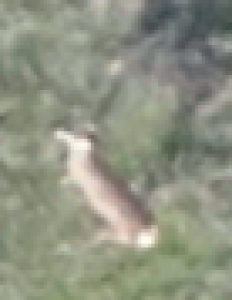

In [15]:
Image.open('/content/small_data_2/test/Ciervos/T-este_def-2-0_1553.png')

In [16]:
# dimensiones a las que vamos a llevar las imágenes
img_width, img_height = 232, 300

normed_dims = (img_height, img_width)

In [17]:
train_data_dir = 'small_data_2/train'
validation_data_dir = 'small_data_2/validation'
test_data_dir = 'small_data_2/test'

batch_size = 16

# **Modelo**

In [18]:
model.input_shape

(None, None, None, 3)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, None, None, 3 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, None, None, 3 0           batch_normalization_95[0][0]     
____________________________________________________________________________________________

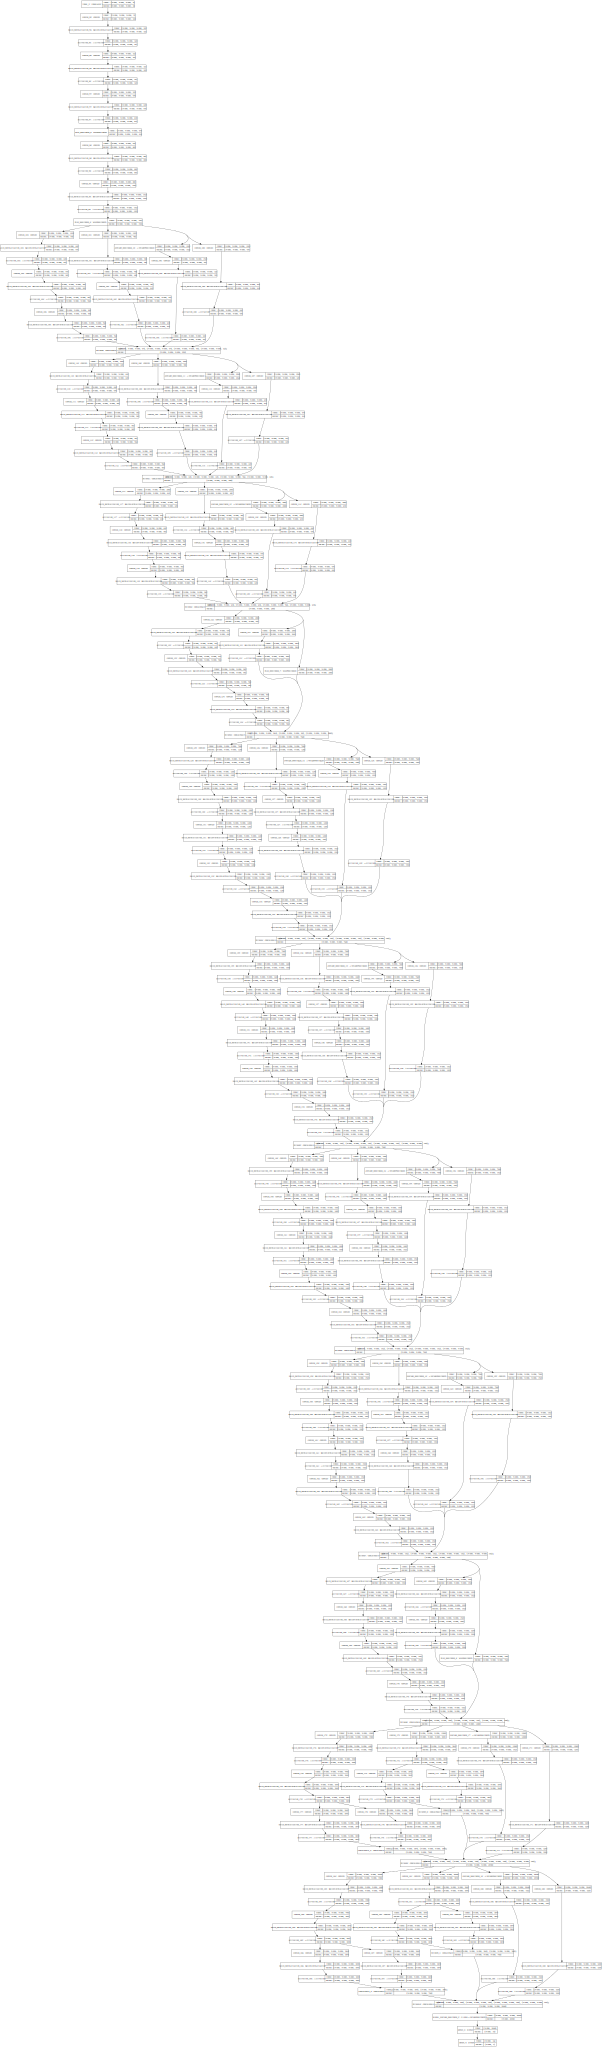

In [19]:
model.summary()
print("\n\n")
if COLAB:
    display(SVG(model_to_dot(model, show_shapes=True, dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

In [20]:
preprocess_input = lambda x:x/255. 

In [21]:
train_datagen = ImageDataGenerator(
    dtype='float32',
    #rescale=1. / 255,
    preprocessing_function = preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen  = ImageDataGenerator(dtype='float32',
                                  #rescale=1. / 255,
                                  preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(dtype='float32',
                                  #rescale=1. / 255,
                                  preprocessing_function = preprocess_input)

In [22]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary')

Found 240 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


In [23]:
train_generator.class_indices

{'Ciervos': 0, 'No_Ciervos': 1}

In [24]:
number_train_samples = train_generator.n
number_val_samples   = validation_generator.n
number_test_samples  = test_generator.n

number_train_samples, number_val_samples, number_test_samples

(240, 80, 80)

## **Resultados obtenidos**

In [25]:
scores_tr = model.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_val = model.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()

scores_te = model.evaluate(test_generator)
print('Test loss     :', scores_te[0])
print('Test accuracy :', scores_te[1])

15/15 [==============================] - 11s 755ms/step
Train loss    : 0.00020642524759750813
Train accuracy: 0.9666666388511658

5/5 [==============================] - 0s 79ms/step
Val loss    : 14.579072952270508
Val accuracy: 0.9750000238418579

5/5 [==============================] - 0s 69ms/step
Test loss     : 0.4230177402496338
Test accuracy : 0.9375


In [26]:
y_real = test_generator.classes
y_pred_proba = model.predict_generator(test_generator)
y_pred = np.round(y_pred_proba)
print('')
print(classification_report(y_real, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.93      0.94        40
           1       0.93      0.95      0.94        40

    accuracy                           0.94        80
   macro avg       0.94      0.94      0.94        80
weighted avg       0.94      0.94      0.94        80



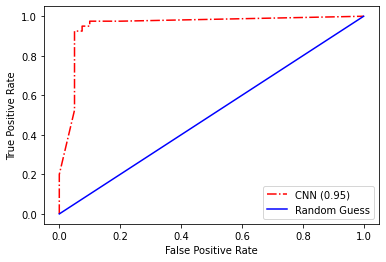

In [27]:
fpr, tpr, thresholds = roc_curve(y_real, y_pred_proba)
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend()
plt.show()

## **Visualización de ejemplos de test**

In [48]:
test_datagen2 = ImageDataGenerator(dtype='float32',
                                   preprocessing_function = preprocess_input)

test_generator2 = test_datagen2.flow_from_directory(
    test_data_dir,
    target_size=normed_dims,
    batch_size=test_generator.n,
    shuffle=False,
    class_mode='binary')

Found 80 images belonging to 2 classes.


In [49]:
test_generator2.reset()
X_te, y_te = test_generator2.next()

In [52]:
test_generator2.class_indices

{'Ciervos': 0, 'No_Ciervos': 1}

Probabilidad No Ciervo: 0.0%


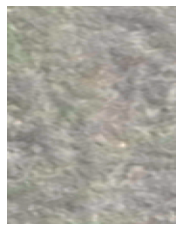

In [51]:
ind_te1 = 50

image = X_te[ind_te1].copy()

plt.imshow(image, cmap='jet')
plt.axis("off")
p = model.predict(preprocess_input(np.array([image])))[0,0]
print("Probabilidad No Ciervo: {:2.2}%".format(100*p))

## **Visualización del funcionamiento de la red**

In [53]:
weights = model.get_weights()
print(np.shape(weights))
for i in range(len(weights)):
    print('shape of weights[%d]: ' % i, np.shape(weights[i]))

(380,)
shape of weights[0]:  (3, 3, 3, 32)
shape of weights[1]:  (32,)
shape of weights[2]:  (32,)
shape of weights[3]:  (32,)
shape of weights[4]:  (3, 3, 32, 32)
shape of weights[5]:  (32,)
shape of weights[6]:  (32,)
shape of weights[7]:  (32,)
shape of weights[8]:  (3, 3, 32, 64)
shape of weights[9]:  (64,)
shape of weights[10]:  (64,)
shape of weights[11]:  (64,)
shape of weights[12]:  (1, 1, 64, 80)
shape of weights[13]:  (80,)
shape of weights[14]:  (80,)
shape of weights[15]:  (80,)
shape of weights[16]:  (3, 3, 80, 192)
shape of weights[17]:  (192,)
shape of weights[18]:  (192,)
shape of weights[19]:  (192,)
shape of weights[20]:  (1, 1, 192, 64)
shape of weights[21]:  (64,)
shape of weights[22]:  (64,)
shape of weights[23]:  (64,)
shape of weights[24]:  (1, 1, 192, 48)
shape of weights[25]:  (3, 3, 64, 96)
shape of weights[26]:  (48,)
shape of weights[27]:  (48,)
shape of weights[28]:  (48,)
shape of weights[29]:  (96,)
shape of weights[30]:  (96,)
shape of weights[31]:  (96,

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


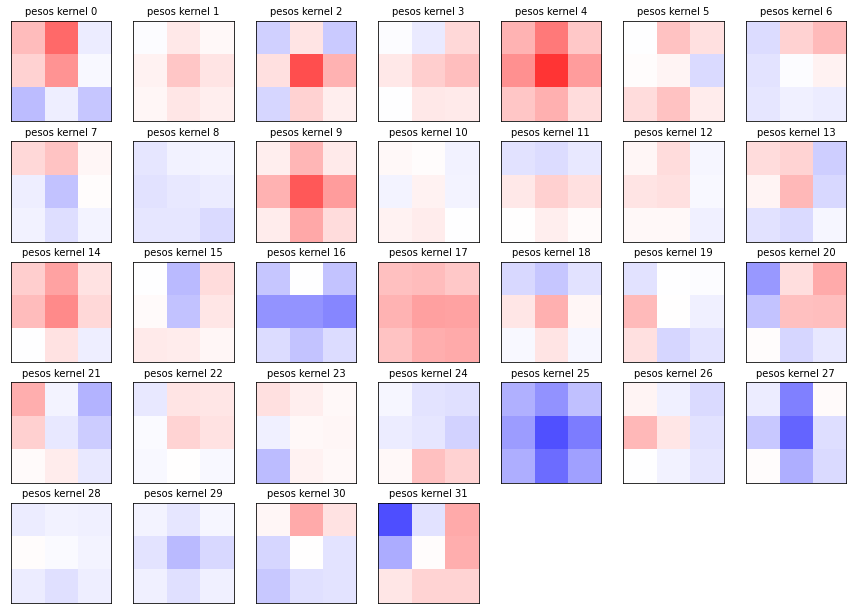

In [54]:
# kernels de la primera capa convolucional
ncapa = 0

nfilters = weights[ncapa].shape[3]
ncols = 7 # número de columnas en la figura


ma = abs(weights[ncapa]).max()
nrows = int(np.ceil(nfilters/ncols)) # número de filas en la figura
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15*nrows/ncols))
axes_r = axes.ravel()
for i in range(nfilters):
    kernel = weights[ncapa][:,:,2,i]
    ax = axes_r[i]
    ax.imshow(kernel, vmin=-ma, vmax=ma, cmap='bwr')
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title('pesos kernel %d' % i, fontsize=10)
for i in range(nfilters,nrows*ncols):
    fig.delaxes(axes_r[i])

### **Visualización de las salidas de una sola capa**

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, None, None, 32)    864       
Total params: 864
Trainable params: 864
Non-trainable params: 0
_________________________________________________________________





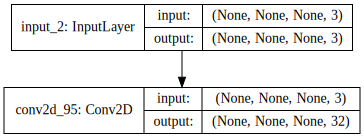

In [55]:
# salida de una sola capa
#ncapa = 0
ncapa = 1

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[ncapa].output)
intermediate_layer_model.summary()
print("\n\n")
if COLAB:
    display(SVG(model_to_dot(intermediate_layer_model,show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(intermediate_layer_model,show_shapes=True).create(prog='dot', format='svg')))

In [114]:
imagen = X_te[10]
imagen.shape

(300, 232, 3)

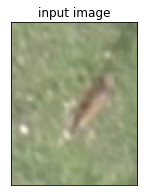

Salidas capa conv2d_95 (1, 149, 115, 32)


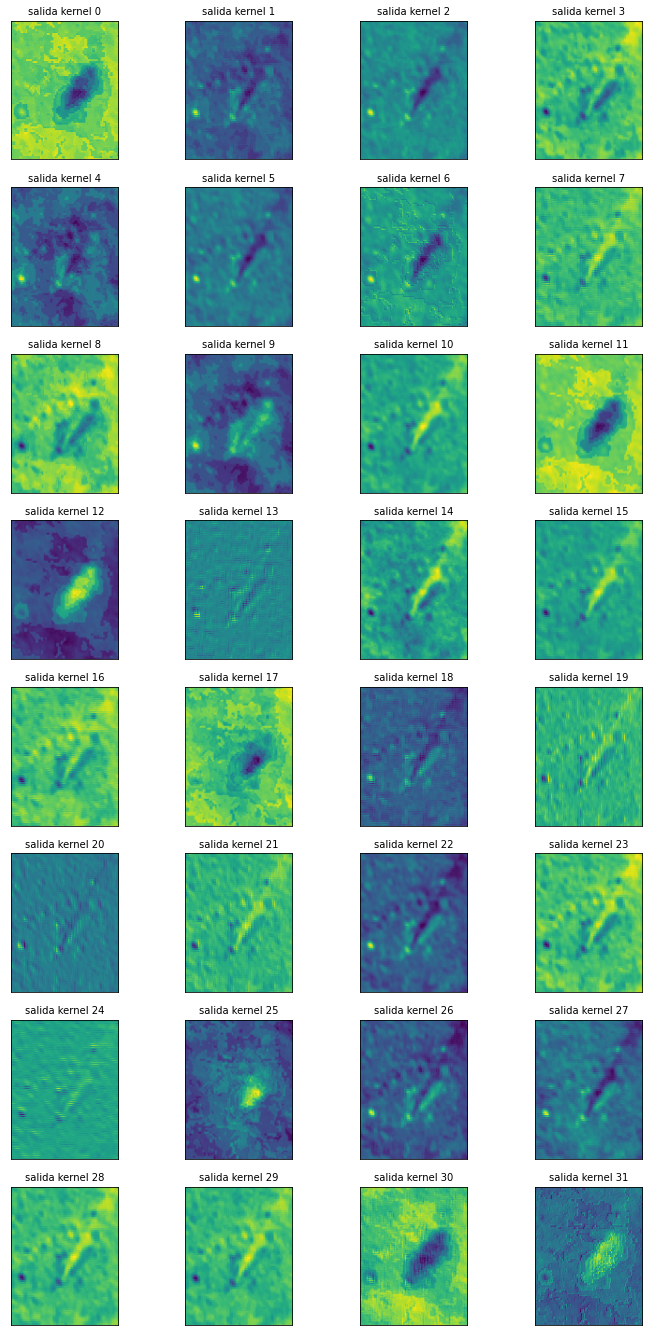

In [57]:
ejemplo = 10

imagen = X_te[ejemplo]
aux = imagen.reshape((1,) + imagen.shape)
salida_capa = intermediate_layer_model.predict(aux)

plt.figure(figsize=(3,3))
plt.imshow(imagen, cmap='gray')
plt.title('input image', size=12)
plt.xticks(())
plt.yticks(())
plt.show()

print("Salidas capa "+intermediate_layer_model.layers[-1].name, salida_capa.shape)

nsalidas = salida_capa.shape[-1]
ncols = 4
nrows = int(np.ceil(nsalidas / ncols))

ma = abs(salida_capa).max()

plt.subplots(nrows,ncols,figsize = (12, 3*nrows))

for i in range(nsalidas):
    plt.subplot(nrows,ncols,i+1)
#    plt.imshow(salida_capa[0,:,:,i], vmin=-ma, vmax=ma, cmap='bwr')
    plt.imshow(salida_capa[0,:,:,i], cmap='viridis')
    plt.xticks(())
    plt.yticks(())
    plt.title('salida kernel %d' % i, fontsize=10)
plt.show()

### **¿A qué partes de la imagen de entrada es más sensible la salida de la red?**

**Funciones que calculan la sensibilidad de la salida a la entrada:**

In [111]:
def find_ind_last_conv2D(model):
    ind_last_conv2D_layer = None
    for i,x in enumerate(model.layers):
        if x.__class__.__name__ == "Conv2D":
            ind_last_conv2D_layer = i
    return ind_last_conv2D_layer

def show_heatmap(model, im):
    imag = np.reshape(im, (1, im.shape[0], im.shape[1], im.shape[2]))
    
    # This is the "no deer" entry in the prediction vector
    output = model.output[:, 0]
    
    # The is the output feature map of the last convolutional layer
    #last_conv_layer = model.layers[4]
    last_conv_layer = model.layers[find_ind_last_conv2D(model)]
    
    # This is the gradient of the "no deer" class with regard to
    # the output feature map of last convolutional layer
    grads = K.gradients(output, last_conv_layer.output)[0]
    
    # This is a vector of shape (64,), where each entry
    # is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    # This function allows us to access the values of the quantities we just defined:
    # `pooled_grads` and the output feature map of the last convolutional layer
    # given a sample image
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    
    # These are the values of these two quantities, as Numpy arrays,
    # given our sample image
    pooled_grads_value, conv_layer_output_value = iterate([imag])
    
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the output of the model
    for i in range(conv_layer_output_value.shape[2]):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    #print(np.max(heatmap))
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    plt.matshow(heatmap)
    plt.xticks([]); plt.yticks([])
        
    img = imag[0]
    
    # We resize the heatmap to have the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        
    # We apply the heatmap to the original image    
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)/255
    
    # 0.4 here is a heatmap intensity factor
    superimposed_img = heatmap * 0.4 + 0.6*img
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(img, vmin=0, vmax=1)
    plt.xticks([]); plt.yticks([])
    plt.subplot(1,3,2)
    plt.imshow(heatmap, vmin=0, vmax=1)
    plt.xticks([]); plt.yticks([])
    plt.subplot(1,3,3)
    plt.imshow(superimposed_img, vmin=0, vmax=1)
    plt.xticks([]); plt.yticks([])
    plt.show()
    print("Probabilidad clase no ciervo:", model.predict(imag)[0][0])
    print("\n\n")
    return heatmap, superimposed_img

**Visualización de mapas de sensibilidades (heatmaps) en varios ejemplos:**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


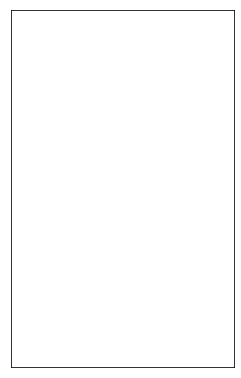

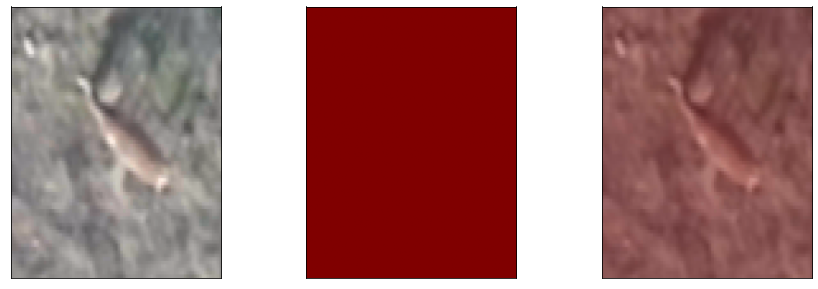

Probabilidad clase no ciervo: 0.0





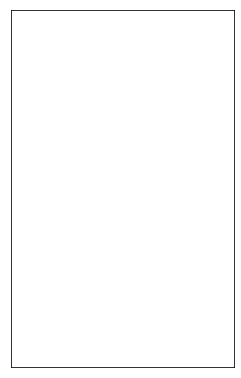

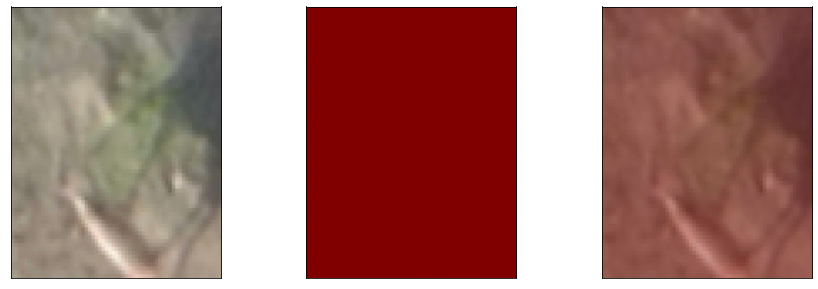

Probabilidad clase no ciervo: 0.0





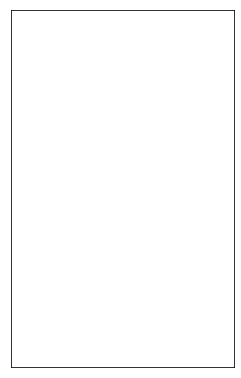

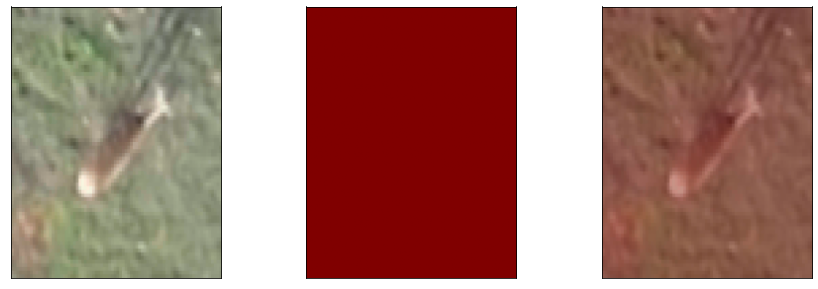

Probabilidad clase no ciervo: 0.0





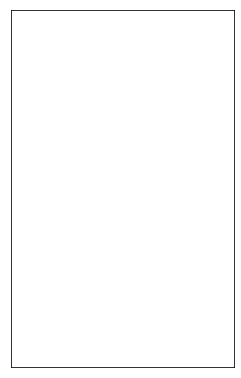

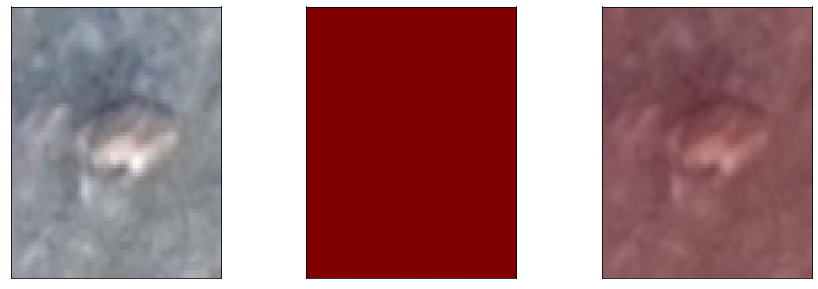

Probabilidad clase no ciervo: 0.0





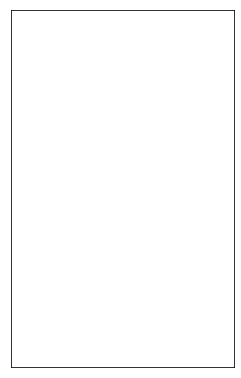

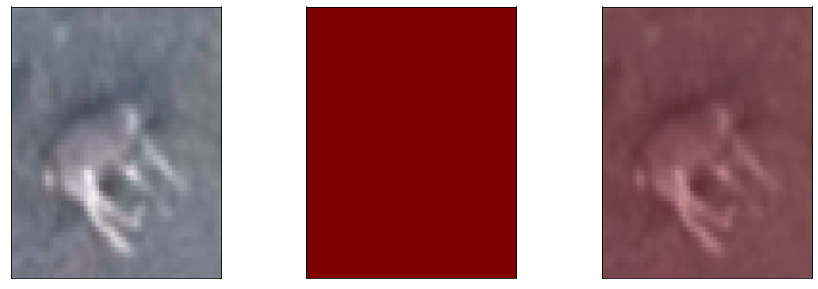

Probabilidad clase no ciervo: 0.0





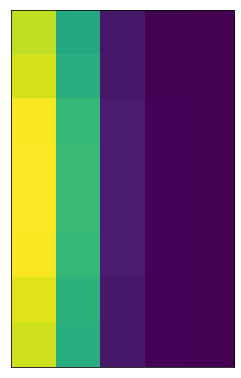

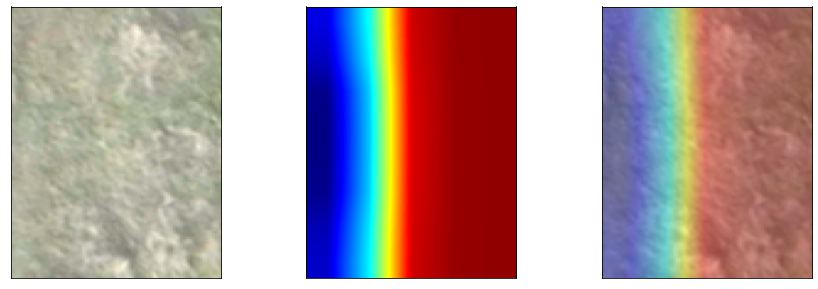

Probabilidad clase no ciervo: 0.99999964





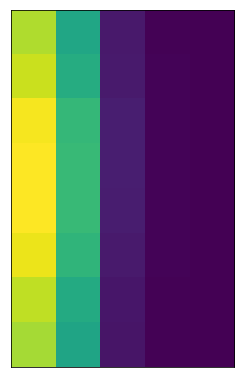

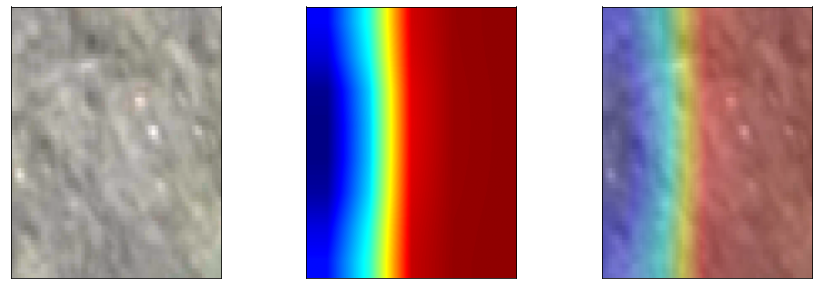

Probabilidad clase no ciervo: 0.99999976





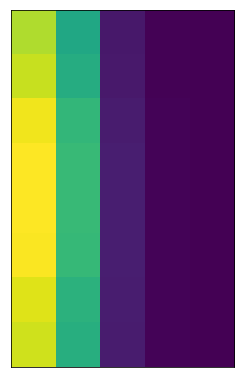

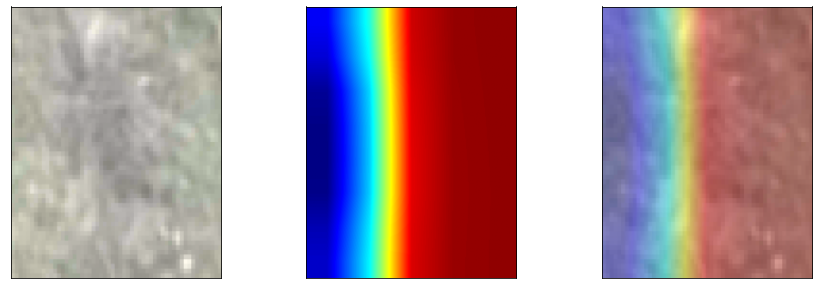

Probabilidad clase no ciervo: 0.99999976





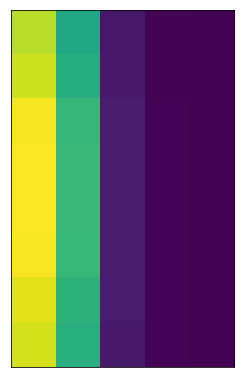

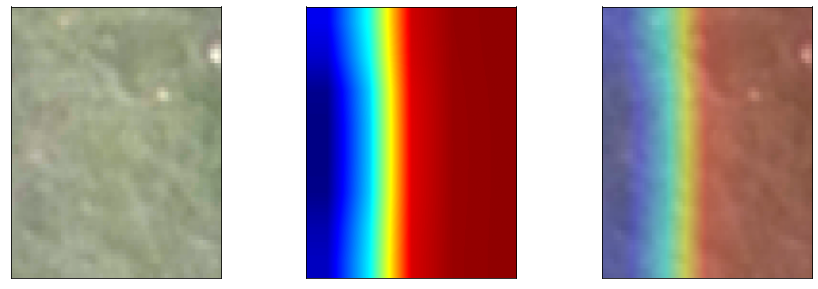

Probabilidad clase no ciervo: 0.99999976





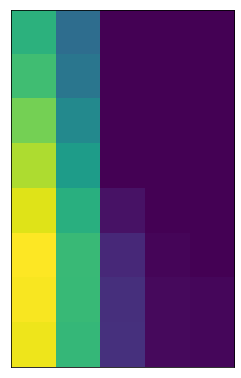

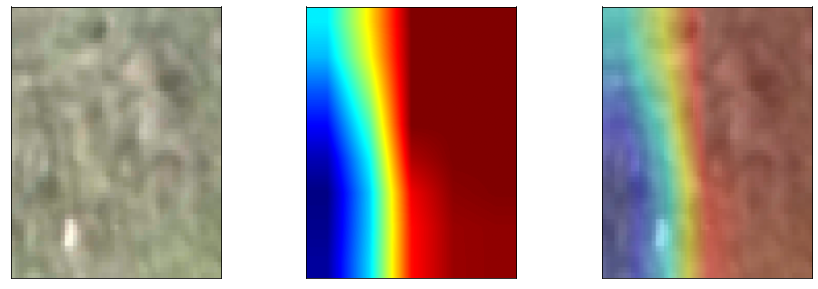

Probabilidad clase no ciervo: 0.9977126





In [112]:
ind = 35 # visualizamos 10 ejemplos de test a partir de este (en test hay 2002 ejemplos)

for i in range(ind, ind+10):
    heat_map, superimposed_img = show_heatmap(model, X_te[i])
    #print(heat_map.min(), heat_map.max(), superimposed_img.min(), superimposed_img.max())

### **Ahora analizamos las mayores equivocaciones de la CNN en test cuando intentamos detectar ciervos**

- clase 1: no ciervo
- clase 0: ciervo

**Ciervos que la red está segura que son no ciervos:**

In [101]:
inds = np.where(y_te==0)[0]
inds = sorted(inds, key=lambda i:y_pred_proba[i])[::-1]
print(inds[:10])
print(y_pred_proba[inds][:10].flatten())

[34, 26, 11, 12, 20, 21, 7, 17, 39, 38]
[9.9999976e-01 9.9999976e-01 9.8028594e-01 9.1146827e-03 1.0788441e-05
 6.4671040e-06 2.2053719e-06 4.1723251e-07 0.0000000e+00 0.0000000e+00]


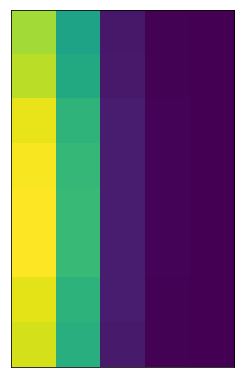

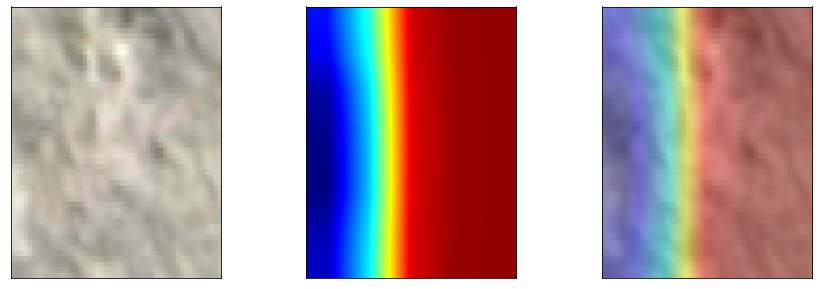

Probabilidad clase no ciervo: 0.99999976





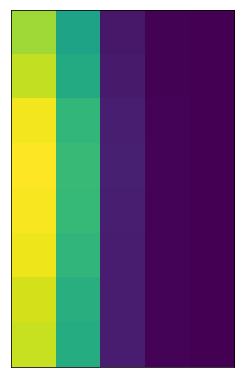

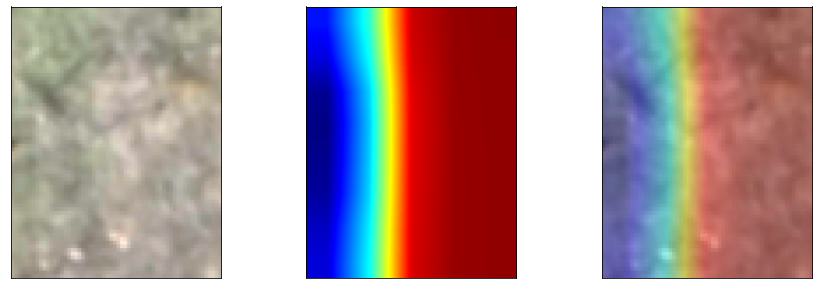

Probabilidad clase no ciervo: 0.99999976





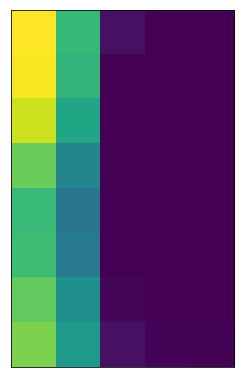

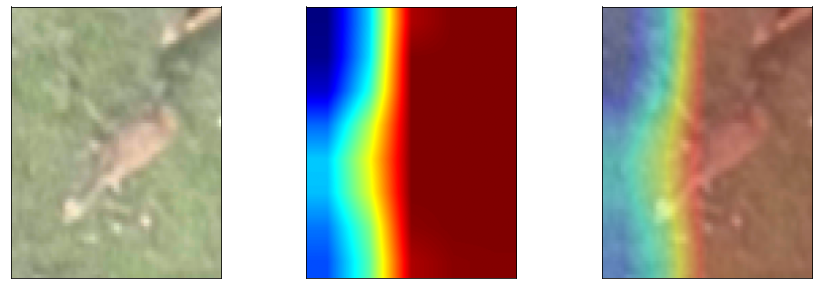

Probabilidad clase no ciervo: 0.9802904





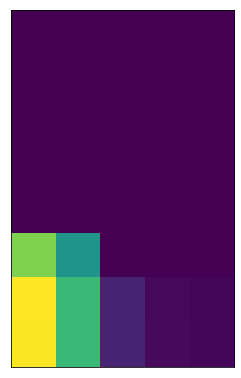

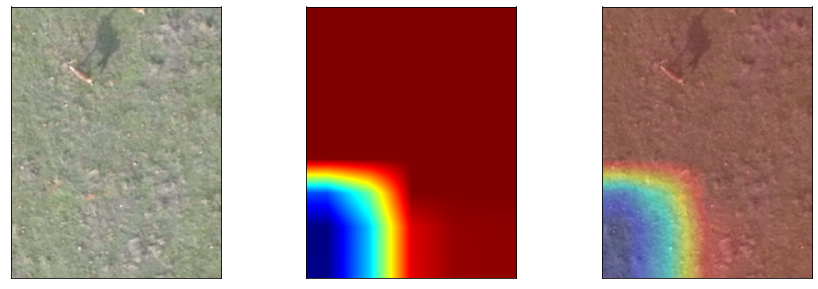

Probabilidad clase no ciervo: 0.009114202





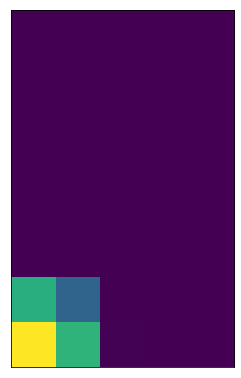

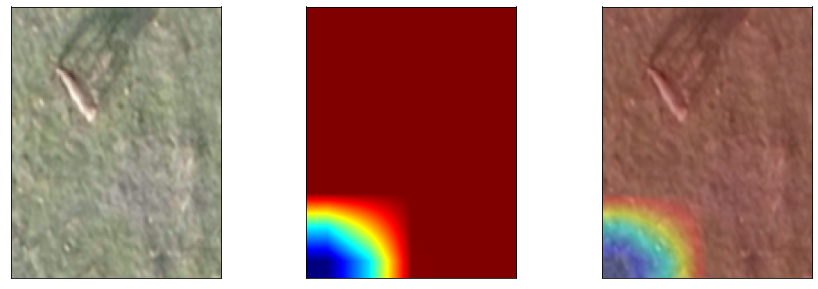

Probabilidad clase no ciervo: 1.0808742e-05





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


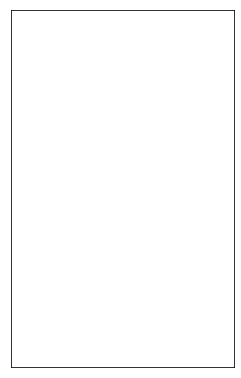

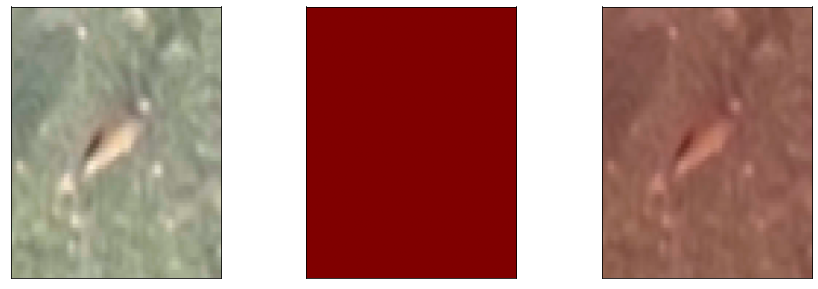

Probabilidad clase no ciervo: 6.481721e-06





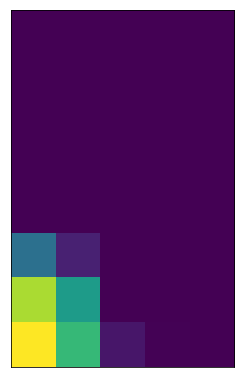

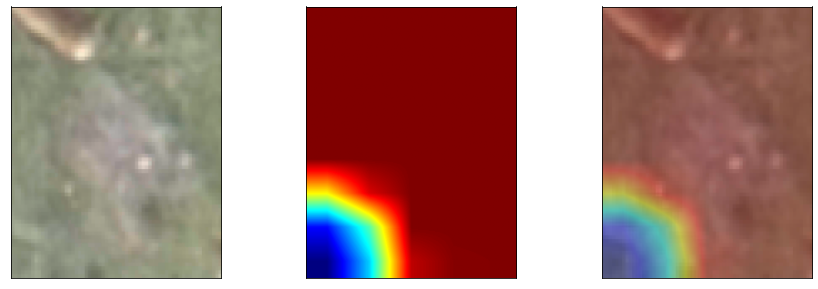

Probabilidad clase no ciervo: 2.169359e-06





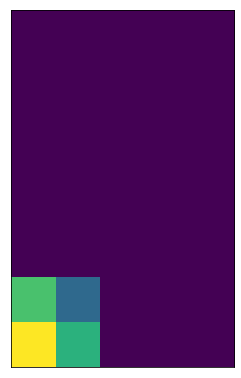

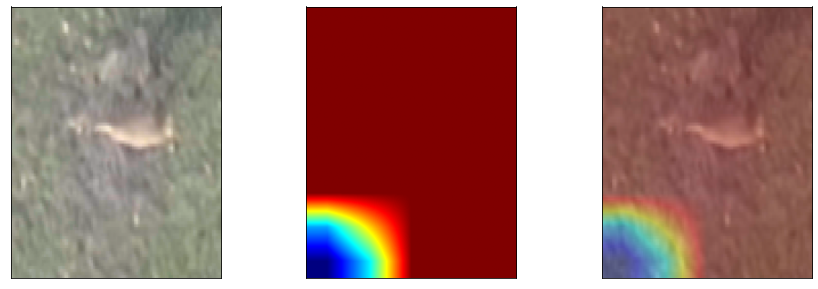

Probabilidad clase no ciervo: 4.195983e-07





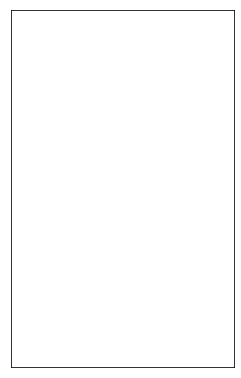

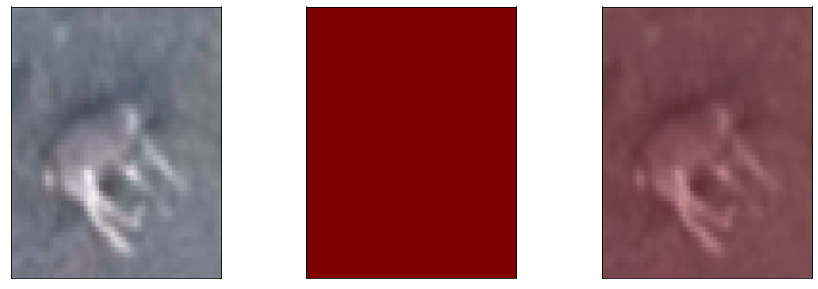

Probabilidad clase no ciervo: 0.0





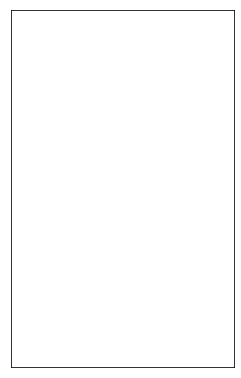

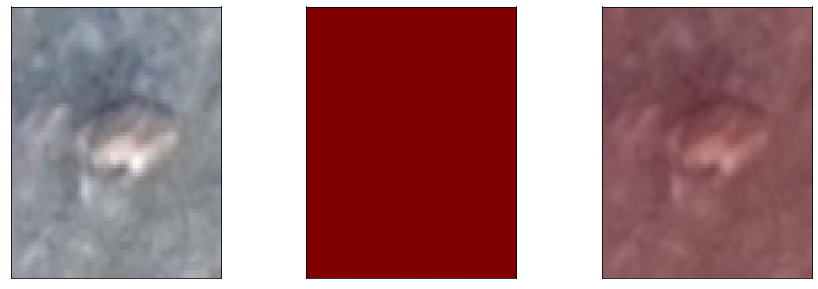

Probabilidad clase no ciervo: 0.0





In [102]:
for i in inds[:10]:
    heat_map, superimposed_img = show_heatmap(model, X_te[i])